# Imports

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle 

In [4]:
ls

building_metadata.csv* test.csv*              weather_train.csv*
eda.ipynb              train.csv*
sample_submission.csv* weather_test.csv*


In [8]:
%%time
root = '../input/ashrae-energy-prediction/'
train_df = pd.read_csv('train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv('weather_train.csv')
test_df = pd.read_csv('test.csv')
weather_test_df = pd.read_csv('weather_test.csv')
building_meta_df = pd.read_csv('building_metadata.csv')
sample_submission = pd.read_csv('sample_submission.csv')


CPU times: user 33.2 s, sys: 3.91 s, total: 37.1 s
Wall time: 30.5 s


In [9]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


In [10]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Dataframes

In [11]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


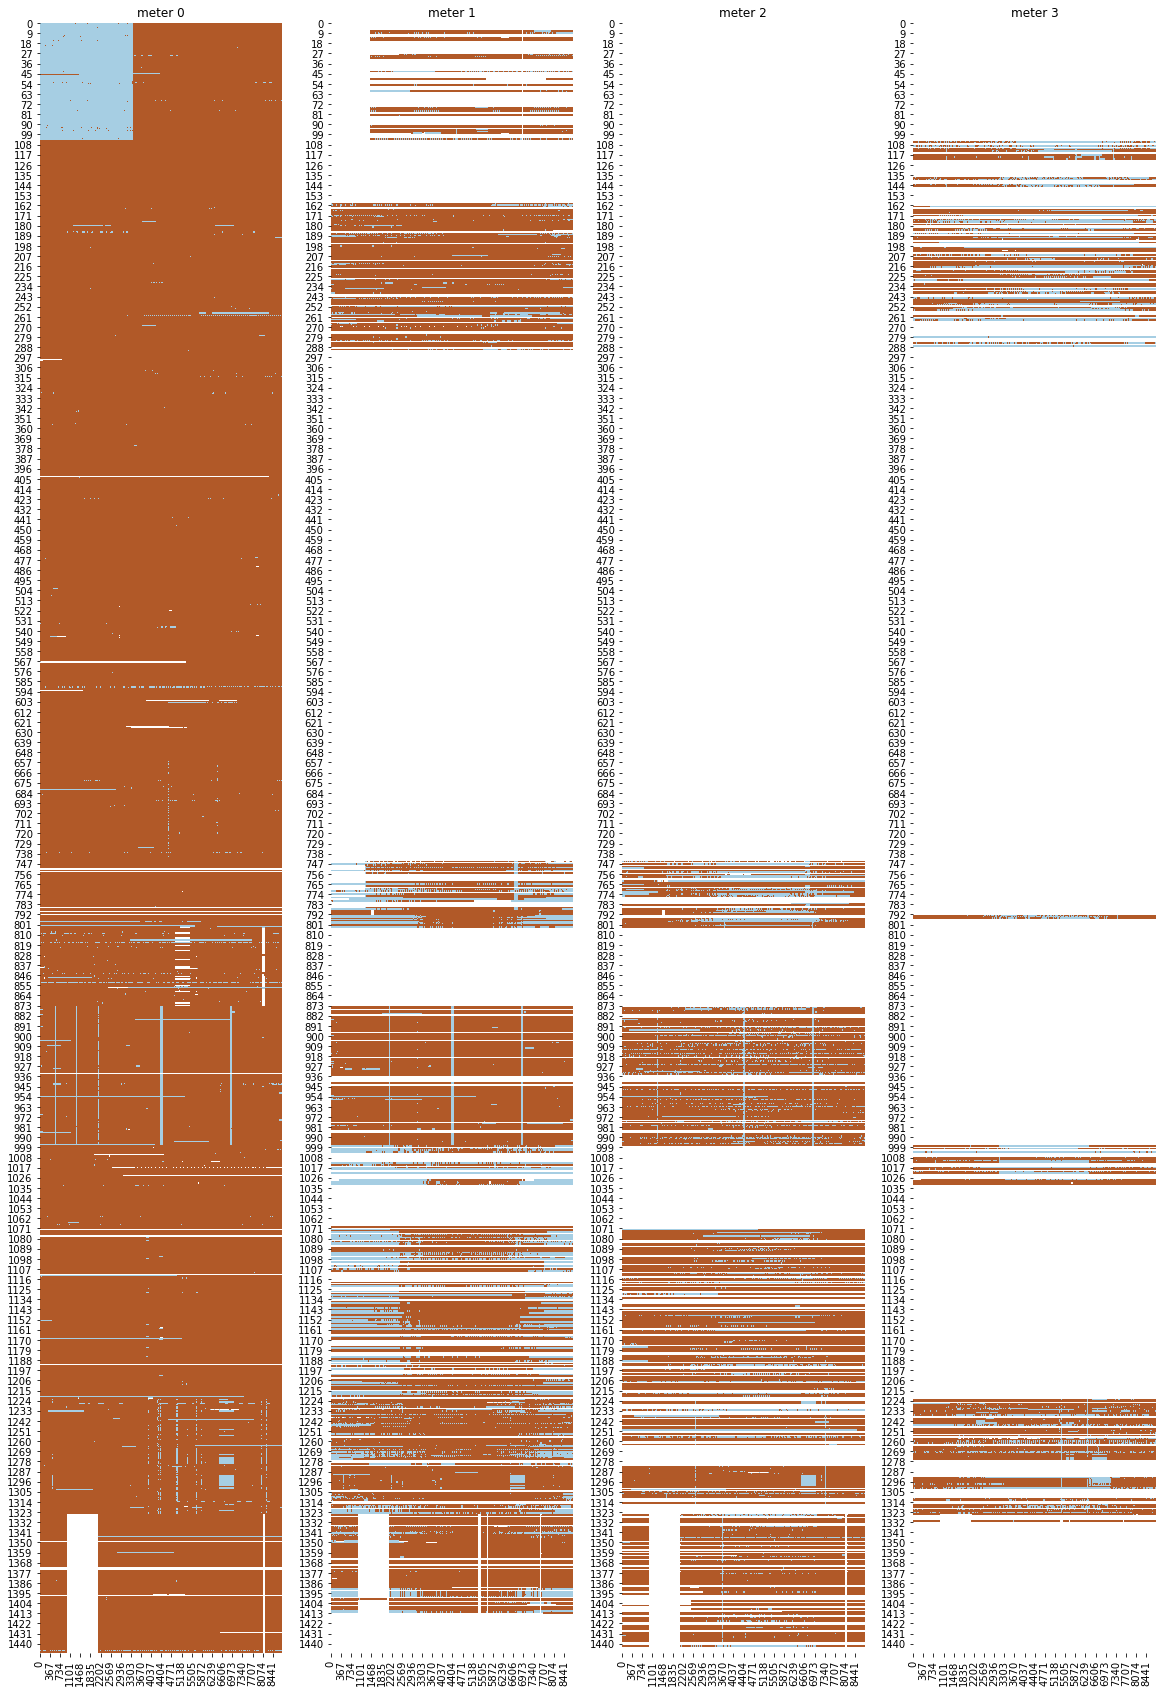

In [12]:
# Load data
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

In [13]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(4)

,Total,Percent
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


In [14]:
# checking missing data
total = weather_train_df.isnull().sum().sort_values(ascending = False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


In [15]:
# checking missing data
total = weather_test_df.isnull().sum().sort_values(ascending = False)
percent = (weather_test_df.isnull().sum()/weather_test_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test_data.head(9)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


In [16]:
# checking missing data
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


In [17]:
train_df.dtypes.value_counts()


float32           1
datetime64[ns]    1
int16             1
int8              1
dtype: int64

In [18]:
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [19]:
# Find correlations with the target and sort
correlations = train_df.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64


In [20]:
corrs = train_df.corr()
corrs

,building_id,meter,meter_reading
building_id,1.000000,0.222268,0.008761
meter,0.222268,1.000000,0.017672
meter_reading,0.008761,0.017672,1.000000


In [21]:
train_df.building_id.nunique()

1449

# Start Models

In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [29]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [30]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [31]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [32]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


# Current